In [1]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('weld_quality_prediction'), '..')))

from data_preprocessing.functions import replace_data, choose_labels, pipeline_training_set
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)

column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

In [3]:
# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Selection of the targets
labels_selected = ["Yield_strength"]

#Replace 'N' value with Nan
data = replace_data(data)

#Selection fof the data for supervised learning
data_with_label = data.copy()
data_with_label = data[data_with_label[labels_selected].notna().all(axis=1)]

#Separation of features and labels
X, y = choose_labels(data_with_label, labels_chosen=labels_selected)


# Random Forest
## Find best hyperparameters with grid search

In [13]:
from itertools import product
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

class ModelSelector:
    
    def __init__(self, *, model_class, labels_selected : list, data, param_grid_data, param_grid_model, kfold_splits):
        self.model_class = model_class
        self.labels_selected = labels_selected
        self.data = data
        self.param_grid_data = param_grid_data
        self.param_grid_model = param_grid_model
        self.kfold_splits = kfold_splits
        
    def extract_x_y(self):
        #Replace 'N' value with Nan
        data = replace_data(self.data)

        #Selection fof the data for supervised learning
        data_with_label = data.copy()
        data_with_label = data[data_with_label[labels_selected].notna().all(axis=1)]

        #Separation of features and labels
        self.X, self.y = choose_labels(data_with_label, labels_chosen=labels_selected)
            
    def split(self, test_size=0.2, random_state=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, shuffle=True, random_state=random_state)

    def cross_validation(self):
        # KFold cross-validation
        kfolds = KFold(n_splits=3)
        
        # Dictionnaire pour stocker les RMSE moyens pour chaque combinaison d'hyperparamètres
        results = {}

        # Générer toutes les combinaisons d'hyperparamètres
        param_grid_total = self.param_grid_data | self.param_grid_model
        keys, values = zip(*param_grid_total.items())
        combinations = list(product(*values))

        # Itérer sur chaque combinaison d'hyperparamètres
        for combo in combinations:
            params = dict(zip(keys, combo))
            
            rmse_list = []  # Pour stocker les RMSE de chaque fold

            for fold, (train_index, val_index) in enumerate(kfolds.split(self.X_train, self.y_train)):
                model = self.model_class(**{k:v for k,v in params.items() if k in self.param_grid_model})
                
                X_sub_train = self.X_train.iloc[train_index, :]
                X_sub_val = self.X_train.iloc[val_index, :]
                y_sub_train = self.y_train.iloc[train_index]
                y_sub_val = self.y_train.iloc[val_index]

                # Appliquer le pipeline avec les paramètres
                X_sub_train, X_sub_val, y_sub_train, y_sub_val = pipeline_training_set(
                    training_set=X_sub_train, training_labels=y_sub_train,
                    testing_set=X_sub_val, testing_labels=y_sub_val, 
                    labels_chosen=labels_selected,
                    categorical_strategy=params['CategoricalStrategies'], 
                    ordinal_strategy=params['OrdinalStrategies'], 
                    is_PCA=True, 
                    pca_percent_explained_variance=0.85,
                    scaler_strategy=params['ScalerStrategy'], 
                    pca_columns=params['PcaColumns'], 
                    less_than_strategy=params['LessThanStrategy']
                )

                # Entraînement et prédiction
                model.fit(X_sub_train, y_sub_train)
                y_sub_pred = model.predict(X_sub_val)
                mse = mean_squared_error(y_sub_pred, y_sub_val)
                rmse = np.sqrt(mse)
                rmse_list.append(rmse)

            # Calculer la moyenne des RMSE pour cette combinaison
            mean_rmse = np.mean(rmse_list)
            results[tuple(combo)] = mean_rmse

        # Trouver les meilleurs hyperparamètres
        best_combo = min(results, key=results.get)
        self.best_rmse = results[best_combo]
        self.best_params = dict(zip(keys, best_combo))

        print(f"Best hyperparameters with cross-validation : {self.best_params}")
        print(f"Best Mean RMSE on cross-validation : {self.best_rmse}")
    
    def score(self):
        # Appliquer le pipeline avec les paramètres
        X_train, X_test, y_train, y_test = pipeline_training_set(
                    training_set=self.X_train, training_labels=self.y_train,
                    testing_set=self.X_test, testing_labels=self.y_test, 
                    labels_chosen=labels_selected,
                    categorical_strategy=self.best_params['CategoricalStrategies'], 
                    ordinal_strategy=self.best_params['OrdinalStrategies'], 
                    is_PCA=True, 
                    pca_percent_explained_variance=0.85,
                    scaler_strategy=self.best_params['ScalerStrategy'], 
                    pca_columns=self.best_params['PcaColumns'], 
                    less_than_strategy=self.best_params['LessThanStrategy']
                )
        model = self.model_class(**{k:v for k,v in self.best_params.items() if k in self.param_grid_model})
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_pred, y_test)
        rmse = np.sqrt(mse)
        print(f"Final RMSE on test set : {rmse}")

In [14]:
# Dictionnaire d'hyperparamètres concernant les données

param_grid_data = {
        'OrdinalStrategies': ["linear"],
        'CategoricalStrategies': ["most_frequent", "logistic"],
        'ScalerStrategy': ["standard", "normalizer"],
        'pca_percent_explained_variance' : [0.75, 0.80, 0.85],
        'PcaColumns': ['concentration', "all_ordinals"],
        'LessThanStrategy': ['mean']
    }

# Dictionnaire d'hyperparamètres concernant les modèles

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [15]:
warnings.filterwarnings('ignore')

model = ModelSelector(model_class=RandomForestRegressor, labels_selected=[
                      "Yield_strength"], data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_rf, kfold_splits = 5)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()

Number of components chosen by PCA: 14
Explained Variance Ratio: [0.13770765 0.10361032 0.08814241 0.08116488 0.06832014 0.05862103
 0.0474831  0.04732457 0.0456145  0.044806   0.03834319 0.03596295
 0.03425988 0.03151038]
Number of components chosen by PCA: 14
Explained Variance Ratio: [0.16529975 0.11585247 0.08202784 0.0740511  0.06086854 0.05207006
 0.05133227 0.04514433 0.04353507 0.03956634 0.0389938  0.03518543
 0.03463154 0.0305947 ]
Number of components chosen by PCA: 14
Explained Variance Ratio: [0.16454076 0.10303714 0.083267   0.0755115  0.06348816 0.05655551
 0.05086366 0.04626636 0.04266358 0.03843478 0.03810359 0.03688572
 0.03584712 0.03243196]
Number of components chosen by PCA: 14
Explained Variance Ratio: [0.13770765 0.10361032 0.08814241 0.08116488 0.06832014 0.05862103
 0.0474831  0.04732457 0.0456145  0.044806   0.03834319 0.03596295
 0.03425988 0.03151038]
Number of components chosen by PCA: 14
Explained Variance Ratio: [0.16529975 0.11585247 0.08202784 0.0740511

Best hyperparameters with cross-validation : 

- 'OrdinalStrategies': 'linear', 
- 'CategoricalStrategies': 'most_frequent',
- 'ScalerStrategy': 'standard', 
- 'pca_percent_explained_variance': 0.75,
- 'PcaColumns': 'concentrations',
- 'LessThanStrategy': 'mean',
- 'n_estimators': 100
- 'max_depth': None
- 'min_samples_split': 2 
- 'min_sample_leaf': 1 

Best Mean RMSE on cross-validation : 54.38299384074454

Final RMSE on test set : 47.7674014760557

# Visualisation

Number of components chosen by PCA: 11
Explained Variance Ratio: [0.15531783 0.10488357 0.08136488 0.07955111 0.064401   0.05543751
 0.04964656 0.04587593 0.04336931 0.03908248 0.03781602]


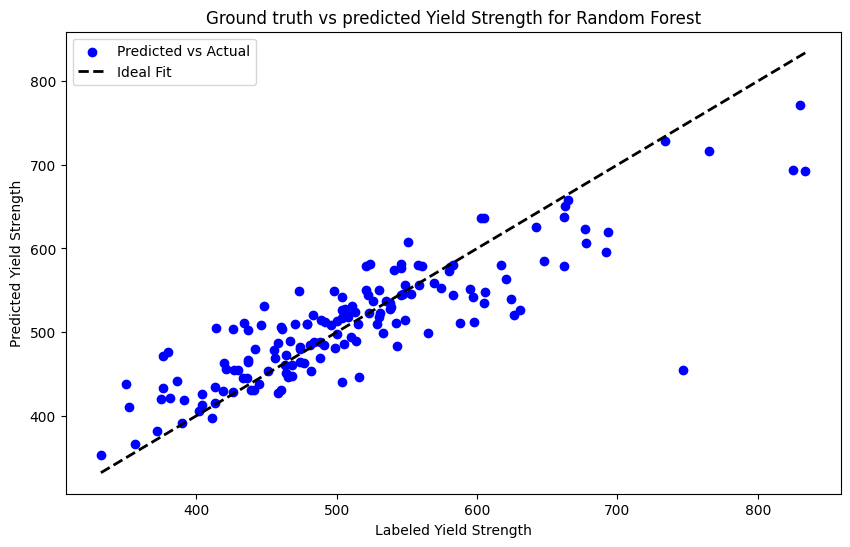

In [19]:
import matplotlib.pyplot as plt
#Selection of the targets
labels_selected = ["Yield_strength"]

#Replace 'N' value with Nan
data = replace_data(data)

#Selection fof the data for supervised learning
data_with_label = data.copy()
data_with_label = data[data_with_label[labels_selected].notna().all(axis=1)]

#Separation of features and labels
X, y = choose_labels(data_with_label, labels_chosen=labels_selected)
 

bestParametersRandomForest = {
    'OrdinalStrategies': 'linear', 
    'CategoricalStrategies': 'most_frequent',
    'ScalerStrategy': 'standard', 
    'pca_percent_explained_variance': 0.75,
    'PcaColumns': 'concentration',
    'LessThanStrategy': 'mean'
}

model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
best_parameters = bestParametersRandomForest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = pipeline_training_set(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test, 
                                                         labels_chosen=labels_selected, categorical_strategy=best_parameters["CategoricalStrategies"], \
                                                        ordinal_strategy=best_parameters["OrdinalStrategies"], is_PCA=True, pca_percent_explained_variance=best_parameters["pca_percent_explained_variance"], \
                                                        scaler_strategy=best_parameters["ScalerStrategy"], pca_columns=best_parameters["PcaColumns"], less_than_strategy=best_parameters["LessThanStrategy"])

model.fit(X_train, y_train)

# Convert new_y_test to a numpy array for plotting
y_test = y_test.values.astype(float)
y_pred = model.predict(X_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Labeled Yield Strength')
plt.ylabel('Predicted Yield Strength')
plt.title('Ground truth vs predicted Yield Strength for Random Forest')
plt.legend()
plt.show()